In [337]:
from qiskit.quantum_info import Operator, Pauli, PTM, pauli_basis
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import depolarizing_error, NoiseModel, pauli_error

import numpy as np
from random import choices, random
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

In [338]:
n=2
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

def get_name(pauli_op):
    try:
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

def conjugate(pauli, cliffordop):
    return get_name(cliffordop.compose(Operator(Pauli(pauli).to_matrix())).compose(cliffordop))

In [339]:
p_group = pauli_basis(n, pauli_list = True).to_labels()
p_group_permuted = [conjugate(p, Operator(CXGate())) for p in p_group]
pairs = list(zip(p_group, p_group_permuted))
print(pairs)

[('II', 'II'), ('IX', 'XX'), ('IY', 'XY'), ('IZ', 'IZ'), ('XI', 'XI'), ('XX', 'IX'), ('XY', 'IY'), ('XZ', 'XZ'), ('YI', 'YZ'), ('YX', 'ZY'), ('YY', 'ZX'), ('YZ', 'YI'), ('ZI', 'ZZ'), ('ZX', 'YY'), ('ZY', 'YX'), ('ZZ', 'ZI')]


II : (1+0j)
IX : (0.8760985446556255+0j)
IY : (0.9305881951818744+0j)
IZ : (0.9005836274822399+0j)
XI : (0.9655289901174212+0j)
XX : (0.9105695545382043+0j)
XY : (0.8961171852992956+0j)
XZ : (0.9350546373648186+0j)
YI : (0.9575179983605743+0j)
YX : (0.9185805462950513+0j)
YY : (0.8881061935424487+0j)
YZ : (0.9430656291216656+0j)
ZI : (0.9230469884779955+0j)
ZX : (0.95305155617763+0j)
ZY : (0.8536351836598699+0j)
ZZ : (0.9775366390042444+0j)


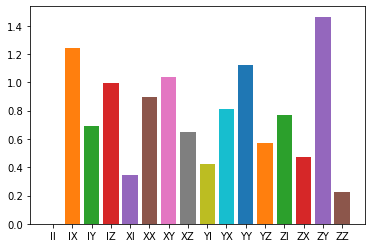

In [340]:
errorgen = 4
errorops = choices(p_group, k=errorgen)
errorprobs = [random()*.1/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli.to_label()] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real)
    print(pauli, ":", transfer_matrix[i][i])

SHOTS = 10000

In [341]:
def get_expectation(circuit, pauli_str):
    circ = circuit.copy()
    circ.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    counts = execute(circ, backend, shots = SHOTS, noise_model = noise_model, basis_gates = noise_model.basis_gates, optimization_level=0).result().get_counts()
    total = 0
    for key in counts.keys():
        pauli_weight = [{"I":'0'}.get(p,'1') for p in pauli_str]
        total += (-1)**sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pauli_weight, key)])*counts[key]
    return total/SHOTS

def measure_circuit(pauli_prep, pauli_meas, depth):
    total = 0
    qc = QuantumCircuit(2)
    for i,p in enumerate(pauli_prep[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.h(i)
                qc.s(i)
    for i in range(depth):
        qc.cx(0,1)
    for i,p in enumerate(pauli_meas[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.sdg(i)
                qc.h(i)
    return qc 

In [342]:
single_pairs = set()
for p1, p2 in zip(p_group, p_group_permuted):
    if 'I' in p1 and not 'I' in p2:
        single_pairs.add((p2,p1))
    if 'I' in p2 and not 'I' in p1:
        single_pairs.add((p1,p2))
print(single_pairs)

{('YZ', 'YI'), ('XY', 'IY'), ('XX', 'IX'), ('ZZ', 'ZI')}


In [343]:
for double, single in single_pairs:
    circ = measure_circuit(double,double,1)
    print(single, get_expectation(circ, single), real_errors[single]) #no spam, otherwise divide by single measurement

YI 0.959 (0.9575179983605743+0j)
IY 0.9248 (0.9305881951818744+0j)
IX 0.8748 (0.8760985446556255+0j)
ZI 0.9218 (0.9230469884779955+0j)


In [344]:
depths = [1,3,5,7,9,11,13]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, single))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(single, "real:", real_errors[single], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

YI real: (0.9575179983605743+0j) measured: 0.9495949989184699 pair: (0.950264338760133+0j)
IY real: (0.9305881951818744+0j) measured: 0.9123455751210617 pair: (0.9131900536794807+0j)
IX real: (0.8760985446556255+0j) measured: 0.8919441979971695 pair: (0.8931677678569923+0j)
ZI real: (0.9230469884779955+0j) measured: 0.9490466608275138 pair: (0.9499011794706695+0j)


In [345]:
depths = [2,4,6,8,10,12,14]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, double))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(double, "real:", real_errors[double], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

YZ real: (0.9430656291216656+0j) measured: 0.9502933289567181 pair: (0.950264338760133+0j)
XY real: (0.8961171852992956+0j) measured: 0.9137752441275736 pair: (0.9131900536794807+0j)
XX real: (0.9105695545382043+0j) measured: 0.8927650032095649 pair: (0.8931677678569923+0j)
ZZ real: (0.9775366390042444+0j) measured: 0.9491591673709797 pair: (0.9499011794706695+0j)


In [346]:
for p1, p2 in pairs:
    circ = measure_circuit(p1, p2, 1)
    res = get_expectation(circ, p2)
    print(p2, "measured:", np.abs(res), "ideal", real_errors[p2])

II measured: 1.0 ideal (1+0j)
XX measured: 0.9092 ideal (0.9105695545382043+0j)
XY measured: 0.8966 ideal (0.8961171852992956+0j)
IZ measured: 0.8884 ideal (0.9005836274822399+0j)
XI measured: 0.9676 ideal (0.9655289901174212+0j)
IX measured: 0.8824 ideal (0.8760985446556255+0j)
IY measured: 0.9324 ideal (0.9305881951818744+0j)
XZ measured: 0.9336 ideal (0.9350546373648186+0j)
YZ measured: 0.9466 ideal (0.9430656291216656+0j)
ZY measured: 0.8528 ideal (0.8536351836598699+0j)
ZX measured: 0.9582 ideal (0.95305155617763+0j)
YI measured: 0.9568 ideal (0.9575179983605743+0j)
ZZ measured: 0.9782 ideal (0.9775366390042444+0j)
YY measured: 0.884 ideal (0.8881061935424487+0j)
YX measured: 0.915 ideal (0.9185805462950513+0j)
ZI measured: 0.9198 ideal (0.9230469884779955+0j)


In [347]:
double_pairs = []
for p1, p2 in pairs:
    if not ("I" in p1 or "I" in p2 or (p2,p1) in double_pairs or p1 == p2):
        double_pairs.append((p1,p2))

print(double_pairs)

[('YX', 'ZY'), ('YY', 'ZX')]


In [348]:
def measure_double(pauli, pauli_pair, depth):
    qc = QuantumCircuit(n)

    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.h(i)
                qc.s(i)

    qc.barrier()
    
    for j in range(depth):
        for i,p in enumerate(zip(pauli[::-1], pauli_pair[::-1])):
            match p:
                case ("X","Y"):
                    qc.s(i)
                case ("X", "Z"):
                    qc.h(i)
                case ("Y", "X"):
                    qc.sdg(i)
                case ("Y", "Z"):
                    qc.sdg(i)
                    qc.h(i)
                case ("Z", "X"):
                    qc.h(i)
                case ("Z", "Y"):
                    qc.h(i)
                    qc.s(i)

        qc.cx(0,1) 
        qc.barrier()
    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.sdg(i)
                qc.h(i)

    return qc

In [349]:
results = []
depths = [2,4,6,8,10,12] #has to be even
for d in depths:
    circ = measure_double("ZX", "YY", d)
    results.append(get_expectation(circ, "ZX"))
popt, pcov = curve_fit(expfit, depths, results)
print("real:", real_errors['ZX'], "measured", np.exp(-popt[1]))

real: (0.95305155617763+0j) measured 0.9527475318337907


In [350]:
sim = Aer.get_backend("qasm_simulator")
circ = measure_double("ZX", "YY", 2)
circ.measure_all()
sim.run(circ).result().get_counts()

{'11': 504, '00': 520}

In [351]:
circ.draw()

┌───┐ ░ ┌───┐           ░ ┌───┐           ░ ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├─░─┤ S ├───────■───░─┤ S ├───────■───░─┤ H ├─░─┤M├───
        └───┘ ░ ├───┤┌───┐┌─┴─┐ ░ ├───┤┌───┐┌─┴─┐ ░ └───┘ ░ └╥┘┌─┐
   q_1: ──────░─┤ H ├┤ S ├┤ X ├─░─┤ H ├┤ S ├┤ X ├─░───────░──╫─┤M├
              ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░       ░  ║ └╥┘
meas: 2/═════════════════════════════════════════════════════╩══╩═
                                                             0  1

In [352]:
def measure_single(single, double):
    results = []
    for d in depths:
        circ = measure_double(double, single, d)
        results.append(get_expectation(circ, double)) 
    popt_double, pcov_double = curve_fit(expfit, depths, results)
    fid_double = np.exp(-popt_double[1])

    circ = measure_double(single, single, 0)
    result0 = get_expectation(circ, single)
    circ = measure_double(double, single, 1)
    result1 = get_expectation(circ, single)
    result = result1/result0
    
    return (result, fid_double**2/result)

In [353]:
print(measure_single("IX", "ZX"))
print((real_errors["IX"], real_errors["ZX"]))

(-0.0084, -100.53635234367866)
((0.8760985446556255+0j), (0.95305155617763+0j))


# Full Procedure

In [354]:
easy_set = set(p1 for (p1, p2) in pairs if p1==p2)
medium_set = set([(p1,p2) for (p1,p2) in pairs if not ("I" in p1 or "I" in p2) and p1 != p2])
hard_set = set([(p1, p2) for (p1, p2) in pairs if (not "I" in p2 and "I" in p1) and not p1 in easy_set])

In [355]:
medium_set

{('YX', 'ZY'), ('YY', 'ZX'), ('ZX', 'YY'), ('ZY', 'YX')}

In [356]:
measured_errors = {}
depths = [2,4,6,8,10,12] #has to be even

for p in easy_set:
    results = []
    for d in depths:
        circ = measure_double(p, p, d)
        results.append(get_expectation(circ, p))
    popt, pcov = curve_fit(expfit, depths, results)
    measured_errors[p] = np.exp(-popt[1])

/home/ben/.local/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [357]:
for p1, p2 in medium_set:
    results = []
    for d in depths:
        circ = measure_double(p1, p2, d)
        results.append(get_expectation(circ, p1))
    popt, pcov = curve_fit(expfit, depths, results) 
    measured_errors[p1] = np.exp(-popt[1])

In [358]:
for single, double in hard_set:
    single_err, double_err = measure_single(single, double)
    measured_errors[single] = single_err
    measured_errors[double] = double_err

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


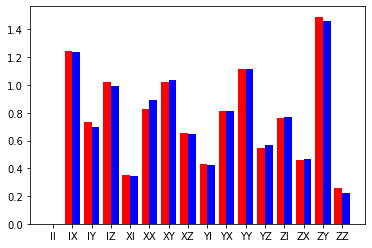

In [359]:
labels = []
real_bar = []
measured_bar = []
for pauli in pauli_basis(2, pauli_list = True).to_labels():
    labels.append(pauli)
    real_bar.append(10*(1-real_errors[pauli]))
    measured_bar.append(10*(1-measured_errors[pauli]))

ax = np.arange(len(labels))
plt.bar(ax+.2, real_bar, .4, color='b')
plt.bar(ax-.2, measured_bar, .4, color='r')
plt.xticks(ax, labels);

Multi-qubit layer

In [360]:
from qiskit.providers.fake_provider import FakeQuito
from qiskit.quantum_info import SuperOp

In [361]:
backend = FakeQuito()
quito_noisemodel = NoiseModel.from_backend(backend)

In [362]:
channel = quito_noisemodel._local_quantum_errors['cx'][(1,2)].to_quantumchannel().data
twirled_channel = np.zeros([16,16])
for p in pauli_basis(2, pauli_list = True):
    mat = p.to_matrix()
    op = np.kron(np.conjugate(mat), mat)
    twirled_channel = np.add(twirled_channel, op @ channel @ op)
trans = PTM(SuperOp(twirled_channel/16)).data
cx_errors = {}
for i,p in enumerate(pauli_basis(2, pauli_list = True).to_labels()):
    cx_errors[p] = trans[i][i]


In [363]:
cx_errors["ZX"]

(0.9494785249240928+0j)

In [364]:
cx_errors["ZZ"]

(0.9469370020930594+0j)